In [ ]:
# default_exp funcs.merfish_codenet

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# export
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.plotting import *
from decode_fish.engine.noise import estimate_noise_scale
import shutil
from decode_fish.funcs.visualization import *
from decode_fish.funcs.predict import predict
import torch.nn as nn
import torch.nn.functional as F
import torch.tensor as T
from decode_fish.funcs.predict import *

from omegaconf import open_dict
from hydra import compose, initialize
from decode_fish.funcs.merfish_eval import *

/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev/lib/python3.9/site-packages/torch/cuda/__init__.py:81: UserWarning: 
    Found GPU2 NVS 510 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


In [ ]:
# cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/sweep_ci_13/start_mic:5000xpsf_noise:0.4/train.yaml')
# cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/sweep_ci_14/enabled:Truexsample_from_codebook:Truexpsf_noise:0.4/train.yaml')
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/sweep_sl_11/seed:1xint_fac:0.1/train.yaml')
csv_name = 'test'
# cfg.foci.n_foci_avg = 0

In [ ]:
# cfg.exp_type.pred_z=False
# cfg.PSF.psf_extent_zyx=[1,21,21]
# cfg.run_name = 'test'

In [ ]:
cfg.foci.n_foci_avg = 0
cfg.training.bs = 10
cfg.PSF.n_cols = 1
cfg.random_crop.crop_sz = 64
model, post_proc, micro, img_3d, decode_dl = load_all(cfg)

Crop size larger than volume in at least one dimension. Crop size changed to (1, 64, 64)
1 volumes


In [ ]:
from decode_fish.funcs.merfish_eval import *
bench_df, code_ref, targets = get_benchmark()
code_inds = np.stack([np.nonzero(c)[0] for c in code_ref])

13832


In [ ]:
# def target_from_matches(matches_df):
    
#     return np.where(matches_df[[f'int_tar_{i}' for i in range(16)]]>0,1,0)

# def verr_from_matches(matches_df):
    
#     gt_code = np.where(matches_df[[f'int_tar_{i}' for i in range(16)]]>0,1,0)
#     pred_int = matches_df[[f'int_pred_{i}' for i in range(16)]].values
    
#     corrs = [np.corrcoef(gt_code[i], pred_int[i])[0,1] for i in range(len(matches_df))]
    
#     return corrs
                    
# def input_from_df(df, from_matches=True):
                    
#     df_str = '_pred' if from_matches else  ''
#     input_keys = ['prob'+df_str,'x_sig'+df_str,'y_sig'+df_str] + ['int'+df_str+f'_{i}' for i in range(16)] + ['int_sig'+df_str+f'_{i}' for i in range(16)]
#     inp_arr = df[input_keys].values
#     return df[input_keys].values

In [ ]:
# export

# def input_from_df(df, from_matches=True):
                    
#     df_str = '_pred' if from_matches else  ''
#     df = get_code_from_ints(df, code_ref, targets, int_str=df_str)
#     matched_codes = code_ref[df['code_inds'].values]
    
#     input_keys = ['prob'+df_str,'x_sig'+df_str,'y_sig'+df_str, 'code_err'] + [f'int_{i}{df_str}' for i in range(16)] + [f'int_sig_{i}{df_str}' for i in range(16)]
#     inp_arr = df[input_keys].values
#     return np.concatenate([df[input_keys].values, matched_codes], 1)

# def input_from_df(df, code_ref, targets, from_matches=True):
                    
#     df_str = '_pred' if from_matches else  ''
#     df = get_code_from_ints(df, code_ref, targets, int_str=df_str)
#     matched_codes = code_ref[df['code_inds'].values]
    
#     input_keys = ['prob'+df_str,'x_sig'+df_str,'y_sig'+df_str, 'code_err'] #+ ['rec_rmses'] + [f'int_sig_{i}{df_str}' for i in range(16)]
#     inp_arr = df[input_keys].values
#     int_sum = df[[f'int_{i}{df_str}' for i in range(16)]].values.sum(-1)[:,None]
#     ints_sum = df[[f'int_sig_{i}{df_str}' for i in range(16)]].values.sum(-1)[:,None]
    
#     return np.concatenate([inp_arr, int_sum, ints_sum], 1)

def input_from_df(df):
                    
    input_keys = ['prob','x_sig','y_sig','p_code_err'] #+ ['rec_rmses'] + [f'int_sig_{i}' for i in range(16)]
    inp_arr = df[input_keys].values
    int_sum = df[[f'int_{i}' for i in range(16)]].values.sum(-1)[:,None]
    ints_sum = df[[f'int_sig_{i}' for i in range(16)]].values.sum(-1)[:,None]
    
    return np.concatenate([inp_arr, int_sum, ints_sum], 1)

# def target_from_matches(matches_df, code_ref, targets):
    
#     matches_df = get_code_from_ints(matches_df, code_ref, targets, int_str='_pred')
#     matched_codes = code_ref[matches_df['code_inds'].values]
    
# #     int_arr = matches_df[[f'int_{i}_tar' for i in range(16)]]
# #     tar_code = np.where(int_arr>0,1,0)
    
#     int_arr = matches_df[[f'int_{i}_tar' for i in range(16)]].values
#     s_arr = np.sort(int_arr)
#     lim = s_arr[:,-5]
#     tar_code = np.stack([np.where(i>l,1,0) for i,l in zip(int_arr, lim)])
#     matches_df[[f'int_{i}_tar' for i in range(16)]] = tar_code
#     matches_df = get_code_from_ints(matches_df, code_ref, targets, int_str='_tar')
#     tar_code = code_ref[matches_df['code_inds'].values]

#     return  1 - abs(np.array(matched_codes, dtype='int') - np.array(tar_code, dtype='int')).max(1)

def extract_rmses(vol, ixy_coords, size_xy = 10, px_size=100):

    rmses = []
    
    for k in range(len(ixy_coords)):

        i, x, y = ixy_coords[k]
        crop = np.s_[int(i),:, np.max([0,int(y/px_size-size_xy)]): int(y/px_size+size_xy+1), np.max([0,int(x/px_size-size_xy)]): int(x/px_size+size_xy+1)]
        
        rmses.append(vol[crop].mean().item())
        
    return rmses

In [ ]:
# export
class code_net(nn.Module):

    def __init__(self, n_inputs=6, n_outputs=1):
        super(code_net, self).__init__()
        
        self.fc1 = nn.Linear(n_inputs, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, n_outputs)
        
    def forward(self, x):
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        x = self.fc4(x)
        return x

net = code_net().cuda()

In [ ]:
from decode_fish.engine.point_process import *
from decode_fish.funcs.output_trafo import *
from decode_fish.funcs.evaluation import *
from decode_fish.engine.gmm_loss import *

num_iters = 100
batch_size = 100
i = 0

bce = torch.nn.BCEWithLogitsLoss()
opt = torch.optim.AdamW(net.parameters(), lr = 5e-3)
sched = torch.optim.lr_scheduler.StepLR(opt, step_size=500, gamma=0.5)
loss_col = []

for i in tqdm(range(num_iters)):

    with torch.no_grad():

        x, local_rate, background = next(iter(decode_dl))
        sim_vars = PointProcessUniform(local_rate*3.,model.int_dist.int_conc, model.int_dist.int_rate, 
                                       model.int_dist.int_loc, channels=16, n_bits=4, sim_z=False, codebook=torch.tensor(code_inds)).sample(from_code_book=True, phasing=cfg.exp_type.phasing)
        xsim = micro(*sim_vars, add_noise=True)
        xsimn = micro.noise(xsim, background, const_theta_sim=False).sample()

        gt_vars = sim_vars[:-1]
        gt_df = sample_to_df(*gt_vars, px_size_zyx=[1.,1.,1.])

        model.eval().cuda()
        res_dict = model(xsimn.cuda())
        res_dict = model.tensor_to_dict(res_dict)
        pred_df = post_proc.get_df(res_dict)
        
        perf, matches, _ = matching(px_to_nm(gt_df), pred_df, tolerance=200, print_res=False)
        
        pred_df = get_code_from_ints(pred_df, code_ref, targets, int_str='')
        pred_df = pred_df.set_index('loc_idx')
        matches = get_code_from_ints(matches, code_ref, targets, int_str='_tar')
        pred_df.loc[matches['loc_idx_pred'],'matched_code'] = matches['code_inds'].values
        pred_df['gt_match'] = np.zeros(len(pred_df))
        pred_df.loc[pred_df['code_inds']==pred_df['matched_code'], 'gt_match'] += 1
        
        get_p = get_code_from_ints(pred_df, code_ref, targets, int_str='', p_str='p_')
        pred_df['p_code_err'] = get_p['code_err']
#         res_dict = post_proc.get_si_resdict(res_dict, p_si=None)
#         ch_img_col = []
#         for i in range(16):
#             locations, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape = post_proc.get_micro_inp(res_dict, p_si=res_dict['Probs_si'], channel=i)
#             ch_img_col.append(micro(locations, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape, rec_ch=i))  
#         rec = torch.cat(ch_img_col, dim=1) + res_dict['background']
#         rmse_vol = torch.sqrt((xsimn - rec)**2).mean(1)

#         ixy_coords = matches.loc[:,['frame_idx_pred', 'x_pred', 'y_pred']].values
#         rmses = extract_rmses(rmse_vol,ixy_coords)
        
#         matches['rec_rmses'] = rmses
    
#     matches = matches.sample(frac=1).reset_index(drop=True)
    pred_df = pred_df.sample(frac=1).reset_index(drop=True)
        
    for b in range(len(matches)//batch_size):

        opt.zero_grad()

        net_inp = T(input_from_df(pred_df[b*batch_size:(b+1)*batch_size]), dtype=torch.float32).cuda()
        net_out = net(net_inp)

        net_tar = T(pred_df[b*batch_size:(b+1)*batch_size]['gt_match'].values, dtype=torch.float32).cuda()
        loss = bce(net_out, net_tar[:,None])
        
        loss.backward()
        
        opt.step()
        sched.step()
        
        loss_col.append(loss.item())

  0%|                                                                    | 0/100 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
from scipy.signal import savgol_filter

window = 51
order = 2
y_sf1 = savgol_filter(loss_col, window, order)
# plt.plot(y_sf2)
plt.plot(y_sf1)
# plt.plot(loss_col)
plt.show()

In [ ]:
image_paths = sorted(glob.glob(cfg.data_path.image_path))
inf_df = merfish_predict(model, post_proc, image_paths, window_size=[None, 256, 256], device='cuda')

In [ ]:
out_vals = []
inf_df = get_code_from_ints(inf_df, code_ref, targets, int_str='')
get_p = get_code_from_ints(inf_df, code_ref, targets, int_str='', p_str='p_')
inf_df['p_code_err'] = get_p['code_err']

for b in tqdm(range(len(inf_df)//100 + 1)):
    if len(inf_df[b*100:(b+1)*100]):
        net_inp = T(input_from_df(inf_df[b*100:(b+1)*100]), dtype=torch.float32).cuda()
        net_out = torch.sigmoid(net(net_inp))

        out_vals.append(np.array(cpu(net_out)))

In [ ]:
out_arr = np.concatenate(out_vals)
inf_df['net_qual'] = out_arr

In [ ]:
plt.hist(inf_df['net_qual'])

In [ ]:
inf_df.to_csv(f'../data/results/MERFISH/{csv_name}.csv', index=False)

In [ ]:
from decode_fish.engine.point_process import *
num_iters = 1
i = 0

out_vals = []

df_col = []
pred_col = []

for i in tqdm(range(num_iters)):

    with torch.no_grad():

        x, local_rate, background = next(iter(decode_dl))
        sim_vars = PointProcessUniform(local_rate*1.,model.int_dist.int_conc, model.int_dist.int_rate, 
                                       model.int_dist.int_loc+1, channels=16, n_bits=4, sim_z=False, codebook=torch.tensor(code_inds)).sample(from_code_book=True, phasing=cfg.exp_type.phasing)
        xsim = micro(*sim_vars, add_noise=True)
        xsimn = micro.noise(xsim, background).sample()

        gt_vars = sim_vars[:-1]
        gt_df = sample_to_df(*gt_vars, px_size_zyx=[1.,1.,1.])

        model.eval().cuda()
        res_dict = model(xsimn.cuda())
        res_dict = model.tensor_to_dict(res_dict)
        pred_df = post_proc.get_df(res_dict)
        
        perf, matches, _ = matching(px_to_nm(gt_df), pred_df, tolerance=500, print_res=False)
        
        pred_df = get_code_from_ints(pred_df, code_ref, targets, int_str='', p_str='')
        pred_df = pred_df.set_index('loc_idx')
        matches = get_code_from_ints(matches, code_ref, targets, int_str='_tar')
        pred_df.loc[matches['loc_idx_pred'],'matched_code'] = matches['code_inds'].values
        pred_df['gt_match'] = np.zeros(len(pred_df))
        pred_df.loc[pred_df['code_inds']==pred_df['matched_code'], 'gt_match'] += 1
        
        get_p = get_code_from_ints(pred_df, code_ref, targets, int_str='', p_str='p_')
        pred_df['p_code_err'] = get_p['code_err']

#         res_dict = post_proc.get_si_resdict(res_dict, p_si=None)
#         ch_img_col = []
#         for i in range(16):
#             locations, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape = post_proc.get_micro_inp(res_dict, p_si=res_dict['Probs_si'], channel=i)
#             ch_img_col.append(micro(locations, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape, rec_ch=i))  
#         rec = torch.cat(ch_img_col, dim=1) + res_dict['background']
#         rmse_vol = torch.sqrt((xsimn - rec)**2).mean(1)

#         ixy_coords = matches.loc[:,['frame_idx_pred', 'x_pred', 'y_pred']].values
#         rmses = extract_rmses(rmse_vol,ixy_coords)
        
#         matches['rec_rmses'] = rmses
    
    pred_df = pred_df.sample(frac=1).reset_index(drop=True)
        
    net_inp = T(input_from_df(pred_df), dtype=torch.float32).cuda()
    net_out = torch.sigmoid(net(net_inp))
#     matches[[f'bin_{i}' for i in range(16)]] = np.array(cpu(net_out))

#     net_out = net(net_inp)
    pred_df['net_qual'] = np.array(cpu(net_out))
    
    df_col.append(pred_df)
    
df_col = pd.concat(df_col)
res_df = df_col.reset_index()

100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.01it/s]


In [ ]:
# (res_df['gt_gene'] == res_df['bin_gene']).sum()/len(res_df)

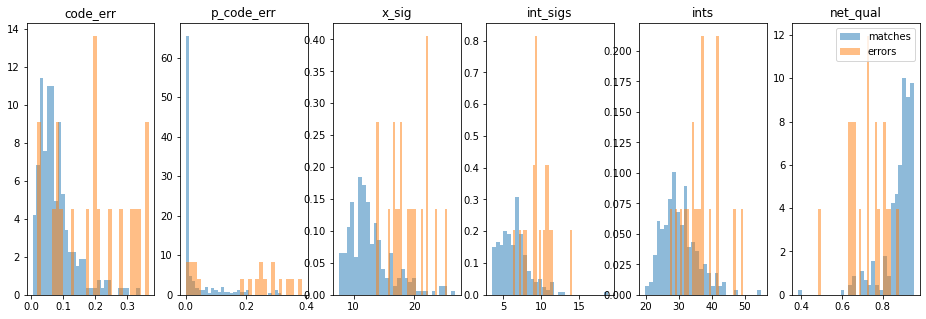

In [ ]:
res_df['int_sigs'] = res_df[[f'int_sig_{i}' for i in range(16)]].values.sum(1)
res_df['ints'] = res_df[[f'int_{i}' for i in range(16)]].values.sum(1)
metrics = ['code_err', 'p_code_err', 'x_sig', 'int_sigs','ints','net_qual']
plt.figure(figsize=(16,5))
for i in range(len(metrics)):
    plt.subplot(1,len(metrics),i+1)
    _=plt.hist(res_df[res_df['gt_match'] == 1][metrics[i]], density=True, alpha=0.5, bins=30, label='matches')
    _=plt.hist(res_df[res_df['gt_match'] == 0][metrics[i]], density=True, alpha=0.5, bins=30, label='errors')
    plt.title(metrics[i])
plt.legend()

In [ ]:
# export
def make_roc(df, var='code_err', ascending=True, n_max=30000):
    
    if n_max is None:
        n_max = len(df)
    x = np.arange(1000,n_max,100)
    df = df.sort_values(var, ascending=ascending)
    n_blanks = []
    for i in x:
        n_blanks.append((df[:i]['gt_match'] == 0).sum())
        
    return x, n_blanks

In [ ]:
from decode_fish.funcs.visualization import *
par_dict = {'code_err':[res_df, 'code_err', True],
            'p_code_err':[res_df, 'p_code_err', True],
            'int_sigs':[res_df, 'int_sigs', True],
#             'rec_rmses':[res_df, 'rec_rmses', True],
            'net_qual':[res_df, 'net_qual', False]}

roc_dict = {}
for k in par_dict:
    x, y = make_roc(*par_dict[k])
    roc_dict[k] = [x, y]

In [ ]:
# roc_dicts = roc_dict

In [ ]:
import seaborn as sns
plt.figure(figsize=(5,5))
# for k in roc_dicts:
#     x, y = roc_dicts[k]
#     plt.plot(x, y, label=k, linestyle='--')
    
for k in roc_dict:
    x, y = roc_dict[k]
    plt.plot(x, y, label=k)
    
plt.legend()
plt.ylim(0, 1000)
plt.xlim(0, 10000)
plt.ylabel('N. errors')
plt.xlabel('N. detections')
sns.despine()

In [ ]:
import seaborn as sns
plt.figure(figsize=(5,5))
# for k in roc_dicts:
#     x, y = roc_dicts[k]
#     plt.plot(x, y, label=k, linestyle='--')
    
for k in roc_dict:
    x, y = roc_dict[k]
    plt.plot(x, y, label=k)
    
plt.legend()
plt.ylim(0, 1000)
plt.xlim(0, 10000)
plt.ylabel('N. errors')
plt.xlabel('N. detections')
sns.despine()

In [ ]:
# for k in inf_df.keys():
#     plt.figure(figsize=(15,10))
#     _ = plt.hist(inf_df[k], bins=51, alpha=0.5, density=True)
#     _ = plt.hist(pred_col[k], bins=51, alpha=0.5, density=True)
#     plt.title(k)
#     plt.show()